In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import mmcv
import matplotlib
import matplotlib.pyplot as plt
import data
import joblib
import torch
import bbox
from bbox import cxcywh2cs
from meva.lib.vibe_loss import VIBELoss
from meva.utils.video_config import update_cfg
from meva.utils import image_utils, kp_utils
from meva.utils.renderer import Renderer
from meva.utils.demo_utils import convert_crop_cam_to_orig_img

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [3]:
res = joblib.load('/media/tormod/Den Lille/Thesis/meva_results/meva_output.pkl')
res.keys()

dict_keys(['pred_cam', 'verts', 'pose', 'betas', 'joints3d', 'joints2d'])

In [29]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
anno_folder = '/media/tormod/Den Lille/Thesis/annotations'
feature_folder = '/media/tormod/Den Lille/Thesis/hmr_features'

cd = data.ClimbingDataset(vid_folder, anno_folder, 'all')#, feat_folder=feature_folder)
cd.get(0).keys()

dict_keys(['raw_imgs', 'norm_imgs', 'features', 'climb_labels', 'kp_2d', 'vid_idx', 'frames', 'bboxes', 'trans', 'inv_trans'])

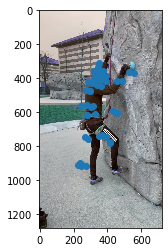

In [19]:
seqidx = 0
frameid = 0
seqinfo = cd.get(seqidx)
inv_trans = seqinfo['inv_trans']
kp_2d = res['joints2d'][seqidx, frameid]
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
kp_2d = image_utils.trans_points2d(kp_2d, inv_trans)
plt.imshow(seqinfo['raw_imgs'][frameid])
plt.scatter(kp_2d[:,0], kp_2d[:,1])
plt.show();


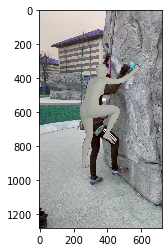

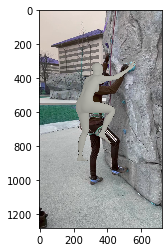

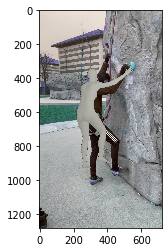

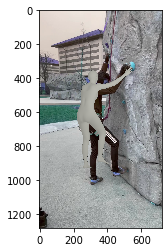

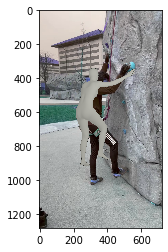

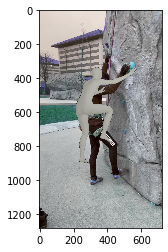

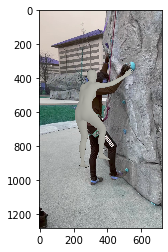

KeyboardInterrupt: 

In [20]:

# make mesh vids
def render_vids(cd, res, out_folder):
    all_verts = res['verts']
    all_pred_cam = res['pred_cam']
    for vid_idx, cumlen in enumerate(np.cumsum(cd.seq_lengths)):
        vid_name = cd.stripped_names[vid_idx]
        start = 0 if vid_idx==0 else cumlen[vid_idx-1]
        orig_height, orig_width, _ = cd.get(start)['raw_imgs'][0].shape
        renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
        for seqidx in range(start, cumlen):
            seq_info = cd.get(seqidx)
            imgs = seq_info['raw_imgs']
            bboxes = seq_info['bboxes']
            bboxcs = cxcywh2cs(bboxes, (orig_height, orig_width))
            bboxcs[:,2:] = bboxes[:,2:]
            frames = seq_info['frames']
            frames = np.arange(frames.start, frames.stop)
            verts = all_verts[seqidx]
            pred_cam = all_pred_cam[seqidx]
            orig_cam = convert_crop_cam_to_orig_img(pred_cam, bboxcs, orig_width, orig_height)
            orig_cam[:,:2] *= 1.2
            for i, v, oc, f, bb in zip(imgs, verts, orig_cam, frames, bboxes):
                mesh_img = renderer.render(i, v, oc)
                plt.imshow(mesh_img)
                plt.show()
                #mmcv.imwrite(mesh_img, f'{out_folder}/{vid_name}/{f:06d}.png')
                
render_vids(cd, res, '/media/tormod/Den Lille/Thesis/meva_out')

In [6]:
config_file = f"meva/cfg/train_meva_2.yml"
cfg = update_cfg(config_file)
loss = VIBELoss(
    e_loss_weight=cfg.LOSS.KP_2D_W,
    e_3d_loss_weight=cfg.LOSS.KP_3D_W,
    e_pose_loss_weight=cfg.LOSS.POSE_W,
    e_shape_loss_weight=cfg.LOSS.SHAPE_W,
)

In [7]:
def vibe_loss(seqidx, res, cd):
    pred_seq = res['joints2d'][seqidx]
    pred_seq = image_utils.normalize_2d_kp(pred_seq, inv=True)
    pred_seq = torch.Tensor(pred_seq)

    seq_info = cd.get(seqidx)
    gt_seq = torch.Tensor(seq_info['kp_2d'])
    return loss.keypoint_loss(pred_seq, gt_seq, 1,1)
    
vibe_loss(0, res, cd)

tensor(1214.2500)

In [52]:
def trans_points(kp_2d, trans):
    shape = kp_2d.shape
    kp_2d = kp_2d.reshape(-1, shape[-1])
    for n_jt in range(kp_2d.shape[0]):
        kp_2d[n_jt, :2] = image_utils.trans_point2d(kp_2d[n_jt], trans)
    kp_2d = kp_2d.reshape(shape)
    return kp_2d

def convert_kp_seq(kp_seq, src, dst):
    for kp_idx in range(kp_seq.shape[0]):
        kp_seq[kp_idx] = kp_utils.convert_kps(kp_seq[kp_idx], src, dst)

def oks(seqidx, res, cd):
    kpt_oks_sigmas = np.array([.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0
    k2 = kpt_oks_sigmas**2
    
    seq_info = cd.get(seqidx)
    inv_trans = seq_info['inv_trans'][0]
    s2 = seq_info['bboxes'][:,-1]**2
    s2 = np.repeat(s2[:,np.newaxis], k2.shape[0], axis=1)
    
    pred_seq = res['joints2d'][seqidx]
    pred_seq = image_utils.normalize_2d_kp(pred_seq, inv=True)
    pred_seq = trans_points(pred_seq, inv_trans)
    pred_seq = np.concatenate((pred_seq, np.ones(pred_seq.shape[:2]+(1,))), axis=2)
    pred_seq = kp_utils.convert_kps(pred_seq, 'spin', 'coco')
    
    gt_seq = seq_info['kp_2d']
    gt_seq = trans_points(gt_seq, inv_trans)
    gt_seq = kp_utils.convert_kps(gt_seq, 'spin', 'coco')
    
    d = np.linalg.norm(pred_seq[:,:,:2] - gt_seq[:,:,:2], axis = 2)
    
    return np.exp(-d/(2*s2*k2))

In [72]:
oks_res = oks(0, res, cd)
oks_res.mean()

0.8883710277495

In [ ]:
# TODO compute AP AR https://cocodataset.org/#keypoints-eval